In [86]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import os
from skimage import exposure
import pydicom
from pydicom.dataset import Dataset, FileDataset
import datetime
import random
FULL_SCAN_ANGLE = 360.0

Funcition turns all .jpg files into bitmap format:

In [87]:
def cutThirdDimension(bitmap):
    if bitmap.ndim == 3:
        return bitmap[..., 0]
    else:
        return bitmap

In [88]:
def scaleBitmap(bitmap):
    return bitmap/255.0

In [89]:
def turnJpgIntoBitmap(directory):  
    bitmap_files = []
    jpg_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith('.jpg')]
    for file in jpg_files:
        img = Image.open(file)
        bitmap = np.array(img)
        bitmap_files.append(scaleBitmap(cutThirdDimension(bitmap)))
    return bitmap_files

In [90]:
def turnDicomIntoBitmap(directory):
    bitmap_files = []
    dicom_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith('.dcm')]

    for file in dicom_files:
        dicom_data = pydicom.dcmread(file)
        bitmap = dicom_data.pixel_array.astype(np.float32)
        bitmap = scaleBitmap(cutThirdDimension(bitmap))  
        bitmap_files.append(bitmap)

    return bitmap_files

In [91]:
def turnSingleJpgIntoBitmap(single_file):
    directory = r"Tomograf-images"
    jpg_file = os.path.join(directory, single_file)
    if single_file.lower().endswith('.jpg'):
        img = Image.open(jpg_file)
        bitmap = np.array(img)
        return scaleBitmap(cutThirdDimension(bitmap))
    else:
        print('Wrong file format')
        exit()
    

In [92]:
def turnSingleDicomIntoBitmap(single_file):
    directory = r"Tomograf-dicom"
    dicom_file = os.path.join(directory, single_file)

    if single_file.lower().endswith('.dcm'):
        dicom_data = pydicom.dcmread(dicom_file)
        bitmap = dicom_data.pixel_array.astype(np.float32)  # Convert to float for stability
        return scaleBitmap(cutThirdDimension(bitmap))
    else:
        print('Wrong file format')
        exit()

In [93]:
def saveBitmapAsJpg(bitmap, filename):
    img = Image.fromarray((bitmap * 255).astype(np.uint8))  # Normalize to 0-255 range
    img.save(filename, format="JPEG")

In [94]:
def saveBitmapAsDicom(bitmap, filename, patient_name, patient_id, date, comment="Generated DICOM image"):
    ds = Dataset()

    # Set required DICOM fields (some set to static or random values)
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.Modality = "CT"
    ds.StudyDate = datetime.datetime.strptime(date, "%d.%m.%Y")
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()
    ds.SOPClassUID = pydicom.uid.CTImageStorage
    ds.ImageType = ["ORIGINAL", "PRIMARY", "AXIAL"]
    ds.InstanceNumber = str(random.randint(1, 100))
    ds.ImagesInAcquisition = "1"
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    # Convert bitmap to DICOM pixel array
    ds.Rows, ds.Columns = bitmap.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0
    ds.PixelData = (bitmap.astype(np.uint16)).tobytes()

    # Set DICOM file meta information
    file_meta = pydicom.dataset.FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    file_meta.ImplementationClassUID = pydicom.uid.generate_uid()
    file_meta.ImplementationVersionName = "PYDICOM 2.0.0"

    ds.file_meta = file_meta

    ds.ImageComments = comment

    # Save as DICOM file
    ds.is_little_endian = True
    ds.is_implicit_VR = False
    ds.save_as(filename, write_like_original=False)

In [95]:
def bresenhamAlgorithm(x1, y1, x2, y2):
    points = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    # Direction of the algorithm
    xi = 1 if x1 < x2 else -1
    yi = 1 if y1 < y2 else -1

    # First pixel
    points.append((x,y))

    if dx > dy:
        # Algorithm operates on the leading axis OX
        
        d = 2*dy - dx
        while x != x2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += yi
                d += 2*(dy-dx)
            else:
                # Move horizzontally
                d += 2*dy
                x += xi
            points.append((x,y))
    else:
        # Algorithm operates on the leading axis OY

        d = 2*dx - dy
        while y != y2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += yi
                d += 2*(dx-dy)
            else:
                # Move vertically
                d += 2*dx
                y += yi
            points.append((x,y))
    return points

In [96]:
def resizeImage(bitmap):
    # Get the dimensions of the input bitmap (rectangle)
    a, b = bitmap.shape

    # If already square just return unchanged
    if a == b:
        return bitmap
    
    size = max(a, b)

    # Create a bitmap with the desired dimensions
    big_bitmap = np.zeros((size, size), dtype=bitmap.dtype)

    # Compute the offsets to center the image
    start_x = (size - a) // 2
    start_y = (size - b) // 2

    # Copy the original bitmap into the center of the new bitmap
    big_bitmap[start_x:start_x + a, start_y:start_y + b] = bitmap

    return big_bitmap

In [97]:
def radonTransform(bitmap , step, detectors_span, detectors_number):
    bitmap = resizeImage(bitmap)

    size = max(bitmap.shape)
    center = size//2
    radius = size//2 - 1

    angles = np.deg2rad(np.arange(0,FULL_SCAN_ANGLE,step))
    span_rad = np.deg2rad(detectors_span)

    sinogram = np.zeros((len(angles), detectors_number), dtype=bitmap.dtype)

    for a_i, angle in enumerate(angles):
        # Emitter coordinates
        x = int(center + radius*np.cos(angle))
        y = int(center + radius*np.sin(angle))

        # Calculate detectors placements for each emiiter 
        for d_i in range(detectors_number):
            # Detector coordinates
            x_d = int(center + radius*np.cos(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))
            y_d = int(center + radius*np.sin(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))

            # Ray between emitter and detector
            bresenham_points = bresenhamAlgorithm(x, y, x_d, y_d)
            
            # Calculate sinogram single point
            total_intensity = np.mean([bitmap[x_b, y_b] for x_b, y_b in bresenham_points if 0 <= x < size and 0 <= y < size])
            sinogram[a_i, d_i] = total_intensity

    return sinogram, bitmap.shape[0]

In [98]:
def filtering(bitmap, kernel_size = 21):
    # Ensure that the kernel size is odd
    if kernel_size%2==0:
        kernel_size += 1
    kernel = np.zeros(kernel_size)	

    # Calculate middle index (kernel is indexed from -k to k są the middle index is k=0)
    middle_idx = kernel_size//2
    kernel[middle_idx] = 1

    # Calculate kernel values for negative k:
    # h[k] = 0, if k is even
    # h[k] = (-4/pi^2)/k^2, if k is odd
    for i in range(1, middle_idx, 2):
        kernel[i] = (-4/(np.pi**2)) / ((i-middle_idx)**2) 

    # Mirror first half of kernel into the second half
    kernel[-middle_idx:] = kernel[:middle_idx][::-1]

    # Use convolution
    for it, i in enumerate(bitmap):
        bitmap[it] = np.convolve(i, kernel, mode='same')
    return bitmap

In [99]:
def inverseRadonTransform(sinogram, resized_size, detectors_span):
    step = FULL_SCAN_ANGLE/sinogram.shape[0]
    detectors_number = sinogram.shape[1]

    center = resized_size//2
    radius = resized_size//2 - 1

    angles = np.deg2rad(np.arange(0,FULL_SCAN_ANGLE,step))
    span_rad = np.deg2rad(detectors_span)

    result_image = np.zeros((resized_size, resized_size), dtype=sinogram.dtype)

    for a_i, angle in enumerate(angles):
        # Emitter coordinates
        x = int(center + radius*np.cos(angle))
        y = int(center + radius*np.sin(angle))

        for d_i in range(detectors_number):
            # Detector coordinates
            x_d = int(center + radius*np.cos(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))
            y_d = int(center + radius*np.sin(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))

            # Ray between emitter and detector
            bresenham_points = bresenhamAlgorithm(x, y, x_d, y_d)

            # Calculate sinogram single point
            for x_b, y_b in bresenham_points:
                if 0 <= x_b < resized_size and 0 <= y_b < resized_size:
                    result_image[x_b, y_b] += sinogram[a_i, d_i]
    return result_image

In [100]:
def cropToOriginal(resized_bitmap, a, b):
    size = resized_bitmap.shape[0]  # Square size

    # Compute the offsets used during centering
    start_x = (size - a) // 2
    start_y = (size - b) // 2

    # Crop the image back to the original size
    cropped_bitmap = resized_bitmap[start_x:start_x + a, start_y:start_y + b]

    return cropped_bitmap

In [101]:
def normalizeImage(bitmap):
    bitmap = np.maximum(bitmap, 0)  # Remove negative values
    max_val = np.quantile(bitmap, 0.999)  # Use the 99.9th percentile for scaling
    bitmap = np.clip(bitmap / max_val, 0, 1) if max_val > 0 else np.zeros_like(bitmap)
    return exposure.equalize_adapthist(bitmap, clip_limit=0.03)

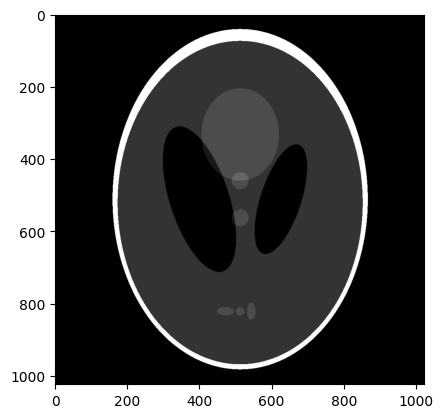

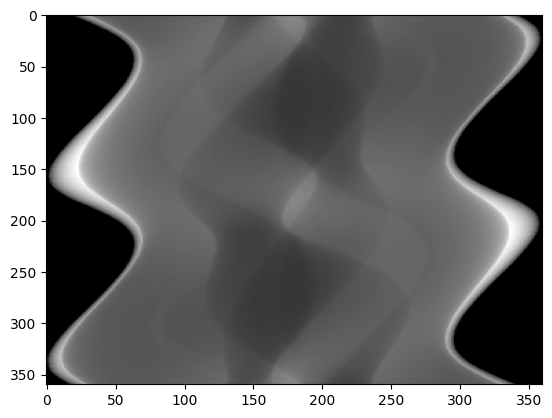

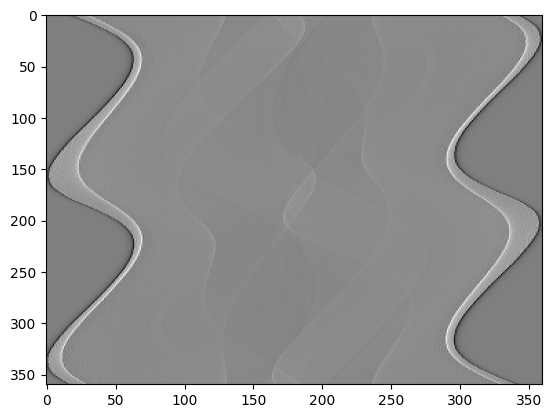

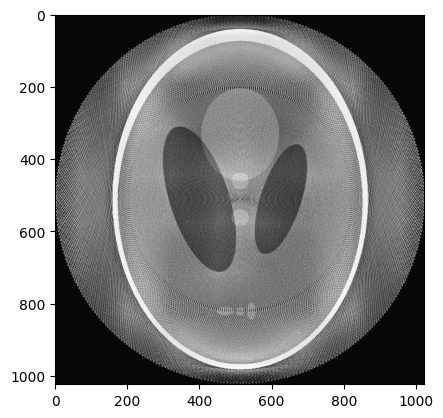

In [102]:
if __name__ == '__main__':

    # Load the DICOM file
    dicom_file = 'Tomograf-dicom/shepp_logan.dcm'  # Replace with your file path
    dataset = pydicom.dcmread(dicom_file)
    
    #For multiple files turning into bitmaps
    # bitmap_files = turnJpgIntoBitmap(r"Tomograf-images")
    # for file in bitmap_files:
    #     plt.imshow(file, cmap='gray')
    #     plt.show()

    #Single file into bitmap
    # bitmap = turnSingleJpgIntoBitmap('Shepp_logan.jpg')

    #Single dicom file into bitmap
    bitmap = turnSingleDicomIntoBitmap('shepp_logan.dcm')
    original_shape_a = bitmap.shape[0]
    original_shape_b = bitmap.shape[1]

    plt.imshow(bitmap, cmap='gray')
    plt.show()

    sinogram, resized_shape = radonTransform(bitmap=bitmap, step=1, detectors_span=270, detectors_number=360)
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.show()

    sinogram = filtering(sinogram, 21)
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.show()

    inversed_bitmap = inverseRadonTransform(sinogram, resized_shape, detectors_span=270)
    inversed_bitmap = cropToOriginal(inversed_bitmap, original_shape_a, original_shape_b)
    normalized_inversed_bitmap = normalizeImage(inversed_bitmap)
    plt.imshow(normalized_inversed_bitmap, cmap='gray')
    plt.show()

    saveBitmapAsJpg(normalized_inversed_bitmap, "test.jpg")
    saveBitmapAsDicom((normalized_inversed_bitmap * 65535).astype(np.uint16), "test.dcm", "Stefan Batory", "1122334455", "15.01.2025", "Comment tmp")
    